# CISC 873 Data Mining - A2 - Speed Dating Match Prediction
## Gavin McClelland - 15gm8 - 10211444
### Due: Monday 18 October 2021, 23:59 EST

⏰⚠ This notebook has been adapted from the provided template "A2_walk_through.ipynb"⚠⏰

# Task 1: Meme Competition

This picture hits home for me as I typically use basic data visualizations in my progress reports at work.

![picture](https://drive.google.com/uc?id=1lzYWZyW5U4YX2jk4ve3Yd6ciZjuD8mD-)

# Task 2: Understand the Template (Trial 0)

In [1]:
import pandas as pd # importing pandas for dataframe operations
import numpy as np # numpy for efficient array/math operations
from sklearn.linear_model import LogisticRegression # baseline logreg model
from sklearn.metrics import f1_score # evaluation metric to discern performance
from pprint import pprint # used to print data structures in a readable format

In [2]:
data = pd.read_csv('/content/train.csv') # training split
data_test = pd.read_csv('/content/test.csv') # testing split
data.shape # prints the dimensions of the training split (5909 samples, )

(5909, 192)

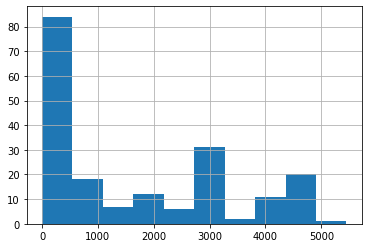

In [3]:
# x-axis: bins containing number of null values
# y-axis: number of columns with # of nulls in that bin
# i.e. from figure, ~85 columns have 0-500 nulls/NaNs
data.isnull().sum().hist()

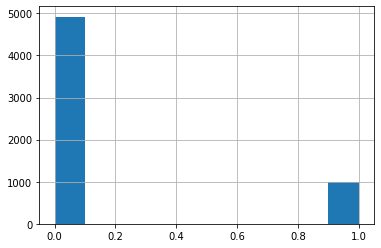

In [4]:
# distribution of target attribute
# highly imbalanced in favour of "no match" (~5:1 ratio)
data['match'].hist()

In [5]:
# down-grade scikit-learn (latest not greatest :) 
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
x = data.drop('match', axis=1) # preparing features for training by removing target attribute
features_numeric = list(x.select_dtypes(include=['float64'])) # get list of all numeric attributes
features_categorical = list(x.select_dtypes(include=['object'])) # get list of all categorical attributes
y = data['match'] # slice of all target attributes/results from training split

In [7]:
print(features_categorical) # printing the list of categorical features

['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income', 'career']


In [8]:
import numpy as np # already imported
from sklearn.compose import ColumnTransformer # used to transform column(s) separate from the rest of the feature space
# from sklearn.datasets import fetch_openml # fetches datasets from openml (i.e. iris dataset)
from sklearn.pipeline import Pipeline # used to combine several transforms into a sequence of operations 
from sklearn.impute import SimpleImputer # imputation transformer, used for missing value replacement
from sklearn.preprocessing import StandardScaler, OneHotEncoder # standard scaler used to convert numeric data to one-scale (would have been useful for last assignment), one hot is used for categorical encoding
from sklearn.linear_model import LogisticRegression # already imported
from sklearn.ensemble import RandomForestClassifier # ensemble classifier, fits several decision trees on several parameter combinations (bagging)
from sklearn.model_selection import train_test_split, GridSearchCV # method to create train and dev/validation splits, and GridSearch for parameter tuning 
from xgboost.sklearn import XGBClassifier # XGBoost classifier - faster, more accurate version of sklearn's GradientBoostingClassifier

np.random.seed(0) # setting the random seed to yield repeatable results

# transformer used to impute missing numeric values
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), # 1st step: impute missing values with the feature median
        ('scaler', StandardScaler())] # 2nd step: convert feature to one scale (unit variance)
)

# transformer used to impute missing categorical values
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # 1st step: replace missing values with literal 'missing'
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # 2nd step: one-hot encodes features, creates a binary column for each category , encodes unknown categories as 0s
    ]
)

# combines transformers pipelines into one transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # 1st step: apply numeric transformer to numeric features
        ('cat', transformer_categorical, features_categorical) # 2nd step: apply categorical transformer to numeric features
    ]
)

# complete pipeline for a random forest classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # 1st step: complete preprocessing transformer
        # 2nd step: initialize random forest classifier (can use another classifier here, too, such as XGB)
        ('my_classifier', 
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(), # using random forest for this example pipeline
        )
    ]
)



# `__` denotes attribute 
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)

# parameter grid used for GridSearch, hyperparameters supplied for both xgb and random forest
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'], # overwriting imputer strategy for numeric transformer 
    # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
    # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
    'my_classifier__n_estimators': [20, 30, 40],    # this is for random forest
    'my_classifier__max_depth':[10, 20, 30]         # this is for random forest
}

# exhaustive search over parameter grid using the complete pipeline for random forest, scored using ROC AUC
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=3, verbose=1, n_jobs=2, # 3 validation folds, 2 jobs run in parallel
    scoring='roc_auc')

grid_search.fit(x, y) # run fit with all parameter sets (exhaustive since we're using grid search) 

print('best score {}'.format(grid_search.best_score_)) # best score from grid search
print('best score {}'.format(grid_search.best_params_)) # best parameter set from grid search

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed:   19.7s finished


best score 0.840205007022898
best score {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 40, 'preprocessor__num__imputer__strategy': 'mean'}


In [9]:
# here we print the dataframe containing all of the results from gridsearch,
# including the score on each split
print('all the cv scores')
pd.DataFrame(grid_search.cv_results_) # printing dataframe of all grid search results

all the cv scores


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_my_classifier__max_depth,param_my_classifier__n_estimators,param_preprocessor__num__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.501835,0.013519,0.088846,0.004068,10,20,mean,"{'my_classifier__max_depth': 10, 'my_classifie...",0.840741,0.823222,0.805865,0.823276,0.014238,3
1,0.658783,0.010809,0.099294,0.004515,10,30,mean,"{'my_classifier__max_depth': 10, 'my_classifie...",0.843386,0.840192,0.827986,0.837188,0.006636,2
2,0.793568,0.015877,0.107466,0.003213,10,40,mean,"{'my_classifier__max_depth': 10, 'my_classifie...",0.844557,0.844573,0.831485,0.840205,0.006166,1
3,0.959238,0.014963,0.086944,0.002331,20,20,mean,"{'my_classifier__max_depth': 20, 'my_classifie...",0.803789,0.817159,0.800729,0.807226,0.007134,7
4,1.341841,0.040307,0.100758,0.001366,20,30,mean,"{'my_classifier__max_depth': 20, 'my_classifie...",0.810470,0.815911,0.798970,0.808450,0.007062,6
5,1.711381,0.032169,0.114952,0.004864,20,40,mean,"{'my_classifier__max_depth': 20, 'my_classifie...",0.833914,0.821931,0.811622,0.822489,0.009109,4
6,1.131955,0.020179,0.091288,0.000890,30,20,mean,"{'my_classifier__max_depth': 30, 'my_classifie...",0.785802,0.811308,0.801220,0.799443,0.010488,9
7,1.581879,0.016834,0.103983,0.003717,30,30,mean,"{'my_classifier__max_depth': 30, 'my_classifie...",0.811664,0.815706,0.793625,0.806998,0.009599,8
8,1.948391,0.139401,0.101186,0.015824,30,40,mean,"{'my_classifier__max_depth': 30, 'my_classifie...",0.824210,0.819891,0.819687,0.821263,0.002086,5


In [10]:
# prepare submission:
submission = pd.DataFrame() # initializing df for recording submission scores
submission['id'] = data_test['id'] # Series of samples for which predictions are being made
submission['match'] = grid_search.predict_proba(data_test)[:,1] # use grid search to predict probability for each sample in test split
submission.to_csv('sample_submission_walkthrough.csv', index=False) # generate submission csv for template
submission # printing submission results dataframe

,id,match
0,934,0.087602
1,6539,0.293644
2,6757,0.172368
3,2275,0.117874
4,1052,0.090979
...,...,...
2464,7982,0.165208
2465,7299,0.290775
2466,1818,0.086282
2467,937,0.106396


In [11]:
from skopt import BayesSearchCV # bayesian optimization from scikit-optimize
from skopt.space import Real, Categorical, Integer # supporting search space dimensions for integer, categorical, and float data 
from sklearn.svm import SVC # support vector classifier used for predicition

# pipeline for SVC model
SVC_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # 1st step: using same preprocessing pipeline as before
        ('my_svc', SVC(class_weight='balanced')) # 2nd step: using an SVC model this time with balanced class weights
    ]
)
# SVC has a class_weight attribute for unbalanced data


# define ranges for bayes search
bayes_search = BayesSearchCV(
    SVC_pipline, # Using SVC pipeline for Bayesian Optimization
    # bayes search parameter 'grid'
    {
        'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform'), # sampling range for regularization parameter C, randomly sampled using log-uniform sampling
        'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'), # sampling range for kernel coefficient gamma
        'my_svc__degree': Integer(1,8), # sampling range for degree of different polynomial classifiers
        'my_svc__kernel': Categorical(['linear', 'poly', 'rbf']), # different kernel types to try
    },
    n_iter=3, # here we're doing 3 iterations where parameters are sampled from the ranges in the specified grid for each iteration
    random_state=0, # random seed used for parameters that are sampled from a uniform distribution (log-uniform in this case)
    verbose=1, # verbosity just specifies how much information is printed
    cv=3, # 3 folds
)

bayes_search.fit(x, y) # run bayes search as specified (3 iterations)



Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.8s finished


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          ['positin1',
                                                                           'pid',
                                                                           'int_corr',
                                                                           'age_o',
                                                             

In [12]:
print('best score {}'.format(bayes_search.best_score_)) # best mean score from bayesian optimization on 3 splits 
print('best score {}'.format(bayes_search.best_params_)) # parameter set on model with best performance

best score 0.8307663023909514
best score OrderedDict([('my_svc__C', 0.0012602593949011189), ('my_svc__degree', 8), ('my_svc__gamma', 2.285959941576884), ('my_svc__kernel', 'poly')])


In [13]:
print('all the cv scores')
pd.DataFrame(bayes_search.cv_results_) # printing results after performing bayesian optimization

all the cv scores


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_my_svc__C,param_my_svc__degree,param_my_svc__gamma,param_my_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.106737,0.917023,1.751879,0.067378,2.35272,6,0.0228543,poly,"{'my_svc__C': 2.352718564818733, 'my_svc__degr...",0.827411,0.824873,0.826816,0.826367,0.001084,2
1,6.396458,0.741238,1.780116,0.056538,0.00126026,8,2.28596,poly,"{'my_svc__C': 0.0012602593949011189, 'my_svc__...",0.835025,0.828426,0.828847,0.830766,0.003017,1
2,6.663504,0.328870,0.922065,0.017950,2.20954,1,0.000248877,linear,"{'my_svc__C': 2.2095350994035026, 'my_svc__deg...",0.793909,0.785279,0.790757,0.789982,0.003565,3


## Answers to Initial Questions
**What is the experimental protocol used and how was it carried out?**

The experimental protocol or procedure used is as follows: First, data preprocessing measures use different strategies for missing value replacement for both numeric and categorical data. Next, a classifier is used to make predictions on the preprocessed dataset. Lastly, hyperparameters were tuned/optimized using different hyperparameter search algorithms (grid search for generating template submission, and bayes search on another classifier--worse performance). This procedure was carried out using pipelines from the scikit-learn API to perform steps in sequence to streamline procedures. Moreover, preprocessing was accomplished using column transformers.

**How did we tune hyper-parameters in the template?**

Hyperparameters were tuned using grid search for the template submission, testing an exhaustive parameter grid to discern the best performance from a set of parameters. Bayes search (or Bayesian Optimization) was used on another classifier (SVC), where parameters are randomly sampled from a distribution for each specified parameter range.

**What is the search space and what is the criteria to determine good/bad hyper-parameters?**

The search space is defined by the range of values for each parameter in the grid. The search space in the template is as follows:

    param_grid = {
    
        'preprocessor__num__imputer__strategy': ['mean'], # overwriting imputer strategy for numeric transformer 
        # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
        # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
        'my_classifier__n_estimators': [20, 30, 40],    # this is for random forest
        'my_classifier__max_depth':[10, 20, 30]         # this is for random forest
    }

In the case of grid search, all combinations in the space are tested (exhaustive). In the case of random search, a fixed number of iterations are specified and random combinations of parameters from the search space are used in each iteration (this takes much less time). In Bayes search, or bayesian optimization, parameter combinations are selected based on a distribution from the grid for a specified number of iterations. 

The criteria used to identify good/bad hyperparameters is the performance metric, where good hyperparameters improve the performance, and bad parameters and parameter values hinder performance. 

# Task 3: Problem Formulation

In this problem, the objective is to predict whether two people will 'match' in a particular speed dating session. The input we are working with consists of a profile of each person in the session, and the output is the prediction of whether there is a successful match, or not (binary classification). AUROC (or ROCAUC) is used as the evaluation metric on the predictions since we are predicting probability of a match as opposed to class labels. The provided dataset has several missing values due to incomplete dating profiles. As such, this will require attention to different preprocessing measures to impute/replace missing values, along with categorical encoding to work with numeric features. After preprocessing, different models will be benchmarked to predict the probability of a successful match. The challenges will be to determine the optimal strategy for replacing missing values, as well as determining the optimal hyperparameters for each model. Three different search algorithms will be used for hyperparameter optimization (Grid Search, Random Search, and Bayesian Optimization). An ideal solution will effectively address these challenges by achieving a missing value replacement strategy that is representative of the dataset, and optimize hyperparameters so the most accurate predictions can be made. The impact of this ideal solution would be understanding the features that lead to successful matches. Moreover, this would create the opportunity to provide informative recommendations for future speed dating sessions.

# Task 4: Model Tuning and Documentation

## Trials 1-3

Thoughts and observations from trial 0 (template): The SVC model performs worse than the random forest classifier, but it uses a different search for optimization (Bayes instead of Grid). Note that the performance is already high (ROCAUC > 0.84), so in reference to the DS tuning life cycle, we should be focused on experimenting with different model architectures and tuning hyperparameters to optimize performance and leaderboard score, which we will do in the following trials.

Plan for trials 1-3:
In these trials, I will try 3 different optimization algorithms (grid search, random search, and bayes search) to tune hyperparameters for the random forest model. I will use similar search spaces and record observations in markdown after each trial.

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# the following functions were adopted from the code in the template

# function to try random search, used throughout notebook
def rsearch(pipeline, parameters, model, itr=10):
  # fits a parameter grid to a pipeline using 5 fold cross-validation, included
  # option to increase number of iterations, which could be preferred for
  # large parameter grids to reduce training time
  rdm = RandomizedSearchCV(
    pipeline, 
    parameters, 
    cv=5,
    n_iter=itr, 
    verbose=3, # most descriptive output
    n_jobs=2,
    scoring='roc_auc'
  )
  rdm.fit(x, y)
  print('best score {}'.format(rdm.best_score_))
  print('best params {}'.format(rdm.best_params_))
  # prepare submission:
  submission = pd.DataFrame()
  submission['id'] = data_test['id']
  submission['match'] = rdm.predict_proba(data_test)[:,1]
  # generate csv with naming convention based on function name
  submission.to_csv(f'random_{model}.csv', index=False)

# function to try bayes search, used throughout notebook 
def bsearch(pipeline, parameters, model, itr=10):
  # Similarly to random search, fits a parameter grid to a pipeline using 
  # 5 fold cross-validation, included option to increase number of iterations,
  # which could be preferred for large parameter grids to reduce training time
  bys = BayesSearchCV(
    pipeline, 
    parameters, 
    cv=5,
    n_iter=itr, 
    verbose=3, 
    n_jobs=2,
    scoring='roc_auc'
  )
  bys.fit(x, y)
  print('best score {}'.format(bys.best_score_))
  print('best params {}'.format(bys.best_params_))
  # prepare submission:
  submission = pd.DataFrame()
  submission['id'] = data_test['id']
  submission['match'] = bys.predict_proba(data_test)[:,1]
  # generate csv with naming convention based on function name
  submission.to_csv(f'bayes_{model}.csv', index=False)

# function to try grid search, used throughout notebook 
def gsearch(pipeline, parameters, model):
  # fits a parameter grid to a pipeline using 5 fold cross-validation using
  # all exhaustive combinations from the parameter grid
  grid = GridSearchCV(
    pipeline, 
    parameters, 
    cv=5,
    verbose=3, 
    n_jobs=2,
    scoring='roc_auc'
  )
  grid.fit(x, y)
  print('best score {}'.format(grid.best_score_))
  print('best params {}'.format(grid.best_params_))
  # prepare submission:
  submission = pd.DataFrame()
  submission['id'] = data_test['id']
  submission['match'] = grid.predict_proba(data_test)[:,1]
  # generate csv with naming convention based on function name
  submission.to_csv(f'grid_{model}.csv', index=False)

In [15]:
# creating a rf pipeline from the provided template
rf_pipeline = Pipeline(
 steps=[
 ('preprocessor', preprocessor), # same preprocessing pipeline
 ('rf', RandomForestClassifier(random_state=0)) # random forest classifier with random seed set for repeatability
 ]
)

# using a wider range of parameters in this grid
rf_params = {
 # trying different numeric imputation strategies, initial in template is 'median'
 # 'most_frequent' is the mode for a given feature
 'preprocessor__num__imputer__strategy': ['mean','median', 'most_frequent'],
 # wider range for number of estimators in the ensemble
 'rf__n_estimators': [10,20,30,40,50,100],
 # wider range for maximum tree depth
 'rf__max_depth':[5,10,20,30,50],
 # trying different criteria for measuring impurity
 'rf__criterion':['gini','entropy'],
 # varying the number of features to include when computing the best split
 'rf__max_features':['auto','sqrt','log2'],
 # assigning balanced weights to each class to handle imbalanced target
 # subsample computes weights based on each bootstrap sample or 'bag' 
 'rf__class_weight':['balanced','balanced_subsample']
}

# since we have a more broad parameter grid, using twice as many iterations for
# random search (20 instead of the default 10)
rsearch(rf_pipeline, rf_params, 'RandomForest', 20)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   22.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.5min finished


best score 0.8451373700179815
best params {'rf__n_estimators': 50, 'rf__max_features': 'sqrt', 'rf__max_depth': 10, 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced_subsample', 'preprocessor__num__imputer__strategy': 'mean'}


Thoughts and observations for trial 1: I would have expected the number of estimators to be higher in the best configuration, but only 20 iterations were run on a broad parameter space, so 100 estimators might not have been in one of the configurations tested. Nonetheless, the performance is a slight improvement from the baseline in the template.

In [16]:
# specifying a parameter grid for bayesian optimization
rf_params_bayes = {
 # again, trying different imputation strategies
 'preprocessor__num__imputer__strategy': Categorical(['mean','median', 'most_frequent']),
 # specifying lower and upper bound for number of estimators to consider
 'rf__n_estimators': Integer(10,500),
 # same with max tree depth
 'rf__max_depth': Integer(5,50),
 # different measures of impurity, max # of features to consider, and class weights
 'rf__criterion': Categorical(['gini','entropy']),
 'rf__max_features': Categorical(['auto','sqrt','log2']),
 'rf__class_weight': Categorical(['balanced','balanced_subsample'])
}

# fit for 20 iterations
bsearch(rf_pipeline, rf_params_bayes, 'RandomForest', 20)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   20.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   20.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   16.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   35.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   34.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   29.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   52.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   15.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   54.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    7.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   11.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished


best score 0.8536083939994541
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('rf__class_weight', 'balanced_subsample'), ('rf__criterion', 'entropy'), ('rf__max_depth', 5), ('rf__max_features', 'sqrt'), ('rf__n_estimators', 447)])


Thoughts and observations for trial 2: Interesting that in only 20 trials, the values for number of estimators and max depth approached the minimum and maximum values. The development score is better than random search as well, likely since Bayes search is somewhat like an informed random search, where it keeps track of good/bad values. I will keep this in mind in subsequent trials when using grid search to narrow down the best parameters. 

In [17]:
# specifying a parameter grid for grid search
rf_params_grid = {
 'preprocessor__num__imputer__strategy': ['mean','median', 'most_frequent'],
 'rf__n_estimators': [10,20,30,40,50,100],
 'rf__max_depth':[5,10,20,30,50],
#  'rf__criterion':['gini','entropy'],
#  'rf__max_features':['auto','sqrt','log2'],
 'rf__class_weight':['balanced','balanced_subsample']
}

# exhaustive search over entire parameter grid
# this takes much longer, so I reduced the parameter grid to focus
# on optimizing the number of estimators and max tree depth
gsearch(rf_pipeline, rf_params_grid, 'RandomForest')

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  8.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 13.9min
[Parallel(n_jobs=2)]: Done 900 out of 900 | elapsed: 16.5min finished


best score 0.850000812205933
best params {'preprocessor__num__imputer__strategy': 'mean', 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 5, 'rf__n_estimators': 100}


Thoughts and observations for trial 3: The performance is worse than the bayes search result, and the training time is significantly longer. Also, grid search is rigid, and does not have the ability to take on values in between specified parameter ranges, which is likely why Bayes search performed better. For example, the model reached a value of 447 for n_estimators in its best parameter set, which was not an explicitly specified value.

## Trials 4-8

Overall thoughts for trials 1-3: Random search is much faster than grid search, and it is also faster than Bayes search. Moreover, random search yields results that are similar to both other searches, despite taking less time. This makes it easier to narrow down the types of parameter values that appear to work well before using grid search or Bayes search to achieve the absolute best set of parameters.

Plan for trials 4-8: I will experiment with different model architectures using random search (less time intensive, and can prototype model architectures more quickly)

In subsequent trials (9 & 10, or until performance appears to max out), I intend to select the two models that perform the best out of the five models selected and use grid search to see if I can improve performance from the random search results

In [18]:
# in this cell I create pipelines for the other models I wish to try

# importing more models to try, KNN and decision tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# creating a pipeline for benchmarking logistic regression
# note that each of these models use the same preprocessing pipeline for imputation and encoding
lr_pipeline = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('logreg', LogisticRegression()) # base logistic regression to be tuned
 ]
)

# pipeline for benchmarking KNN
knn_pipeline = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('knn', KNeighborsClassifier()) # base KNN to be tuned
 ]
)

# pipeline for benchmarking a decision tree classifier
dt_pipeline = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('dt', DecisionTreeClassifier(random_state=0)) # base DT to be tuned, random seed set
 ]
)

# pipeline benchmarking a support vector classifier
svc_pipeline = Pipeline(
    steps=[
     ('preprocessor', preprocessor), 
     # using an SVC model with balanced class weights
     ('svc', SVC(class_weight='balanced', random_state=0, probability=True))
    ]
)

# pipeline for benchmarking an XGBoost classifier
xgb_pipeline = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  # setting the objective function as logistic regression for binary classification
  # outputs the probability as required for this task
  ('xgb', XGBClassifier(objective='binary:logistic', seed=0)) # also set random seed
 ]
)

In each of the following cells, we specify a parameter grid and fit it with random search. If a parameter appears to max out, they will be tweaked to see if we can maximize performance. I will use random search as it is efficient for getting rapid feedback on model performance under different parameter configurations. For each parameter grid, we vary the imputation strategy for numeric data in the preprocessing pipeline.

In [19]:
# starting with logistic regression, we try different regularization methods and
# coefficients, optimization algorithms, max iterations for convergence, and
# experiment with using balanced class weights
lr_params = {
 'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
 'logreg__penalty': ['l2'],
 'logreg__C':[0.1,0.5,1,1.5],
 'logreg__solver':['sag', 'saga'],
 'logreg__max_iter':[100,300,600],
 'logreg__class_weight':['balanced']
}

# use random search for testing different parameter grids
rsearch(lr_pipeline, lr_params, 'logreg', 30) # using more iterations than default

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  6.0min finished


best score 0.8612655873344274
best params {'preprocessor__num__imputer__strategy': 'median', 'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__max_iter': 100, 'logreg__class_weight': 'balanced', 'logreg__C': 0.1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Thoughts and observations for trial 4: Logistic regression performs well across a broad parameter grid. This is my best development score so far Worth noting that the maximum number of iterations was reached for the lower values of max_iter, so higher values were added in subsequent attempts. Leaderboard score was 0.86323.

In [31]:
# next we try KNN, where we vary the number of nearest neighbours, weight
# functions used for prediction, algorithms used to compute nearest neighbours,
# and the distance metric (either manhattan or Euclidean distance)
knn_params = {
 'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
 'knn__n_neighbors': [70,100,120,150],
#  'knn__n_neighbors': [5,10,20,40,60,100],
 'knn__weights':['uniform', 'distance'],
 'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
 'knn__p':[1,2]
}

# running knn for the default 10 iterations
rsearch(knn_pipeline, knn_params, 'knn')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  2.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


best score 0.8206598047041174
best params {'preprocessor__num__imputer__strategy': 'mean', 'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 120, 'knn__algorithm': 'kd_tree'}


Thoughts and observations for trial 5: Across a broad parameter grid, KNN does not perform as well as the other options. However, it does perform reasonably well, and is quick to train. The first attempt performed the best with 100 neighbors, so subsequent attempts tried to use higher values until performance stopped improving. Leaderboard score was 0.83299, which could be worse, but I think other models would suit this problem better.


In [21]:
# I know I've already done a random forest classifier in the template,
# but I thought it would be good to see the performance gap between an ensemble
# and a single tree, varying most parameters as these are quick to train
dt_params = {
 'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
 'dt__criterion': ['gini','entropy'],
 'dt__splitter': ['best','random'],
 'dt__max_depth': [5,10,15,20],
 'dt__min_samples_leaf': [1,2,3,5,10],
 'dt__max_features': ['auto','sqrt','log2'],
 'dt__class_weight': ['None','balanced']
}

# running random search using more parameters as the 
rsearch(dt_pipeline, dt_params, 'dt', 50)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   19.3s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:   39.1s finished


best score 0.6960767565173208
best params {'preprocessor__num__imputer__strategy': 'most_frequent', 'dt__splitter': 'best', 'dt__min_samples_leaf': 10, 'dt__max_features': 'auto', 'dt__max_depth': 20, 'dt__criterion': 'entropy', 'dt__class_weight': 'balanced'}


Thoughts and observations for trial 6: The performance of a single decision tree isn't very good, despite search a very broad parameter grid across 50 iterations. This could be due to the model overfitting to the training data and failing to generalize to the validation splits (high variance). This issue appears to be addressed by the ensemble models as they perform much better (>0.83 ROCAUC). I did not bother submitting these results to the public leaderboard.

In [22]:
# Next I'll try to optimize the support vector classifier from the provided template.
# Here, I vary the regularization parameter C, polynomial degree, and kernel coefficient, gamma.
# svc_params = {
#     'svc__C': [0.001,0.0025,0.005,0.01],
#     'svc__degree': [7,8,9,10],
#     'svc__gamma': [1,2,3],
#     'svc__kernel': ['poly'],
#     'svc__max_iter':[1000]
# }
# rsearch(svc_pipeline, svc_params, 'svc')

# define ranges for bayes search
svc_params = {
  'svc__C': Real(1e-6, 1e+6, prior='log-uniform'), # sampling range for regularization parameter C, randomly sampled using log-uniform sampling
  'svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'), # sampling range for kernel coefficient gamma
  'svc__degree': Integer(1,8), # sampling range for degree of different polynomial classifiers
  'svc__kernel': Categorical(['linear', 'poly', 'rbf']), # different kernel types to try
}
bsearch(svc_pipeline, svc_params, 'svc', 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.1min finished


best score 0.8401299424166243
best params OrderedDict([('svc__C', 3.1468579713776803), ('svc__degree', 3), ('svc__gamma', 0.18336394419123478), ('svc__kernel', 'linear')])


Thoughts and observations for trial 7: I do not know why, but this did not appear to converge until a finite number of iterations were specified, even for one iteration. The score for random search on the parameter space above (now "commented out") was <0.60, so I tried bayesian optimization as outlined in the template to see if I could improve the score in the template, which was ~0.83, and still acheived a similar score here.

In [23]:
# last and definitely not least, I'll try out XGBoost, which is commonly
# known as a powerful and efficient version of sklearn's GradientBoostingClassifier()
# For this trial, I'll start by varying the number of estimators and max tree depth
# from the provided template
xgb_params = {
 # attempt 1
#  'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
#  'xgb__n_estimators': [20,30],
#  'xgb__max_depth':[10,20]

 # attempt 2
#  'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
#  'xgb__n_estimators': [30,50,100],
#  'xgb__max_depth':[3,5,7,10]

 # attempt 3
 'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
 'xgb__n_estimators': [100,200,500],
 'xgb__max_depth':[5,7,10,15],
 'xgb__subsample':[0.6,0.8,1],
 'xgb__colsample_bytree':[0.5,1],
}

# starting with just 10 iterations as the performance should be good to begin with
rsearch(xgb_pipeline, xgb_params, 'xgb')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  8.1min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 11.6min finished


best score 0.8813002047530043
best params {'xgb__subsample': 1, 'xgb__n_estimators': 200, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.5, 'preprocessor__num__imputer__strategy': 'mean'}


Thoughts and observations for trial 8: XGBoost is a powerful model in applied machine learning, and in this particular application it is clear to see why. The results for three attempts using random search across different parameter grids are listed below.
*   attempt 1 - 0.866
*   attempt 2 - 0.878
*   attempt 3 - 0.881 (leaderboard score 0.88121)

It is clear that tuning certain hyperparameters and increasing parameter ranges made a significant improvement on performance. Now that I have a decent idea of what parameter ranges I want to test using grid search to get a better score.



## Trials 9 & 10+

General observations from trials 4-8: the models performing the best are xgboost and random forest, likely due to their respective applications of bagging and boosting, which improves the prediction accuracy on difficult samples. Logistic Regression also performs well, but the decision tree classifier and KNN models perform poorly, likely due to their simplicity. In the final trials, I will try to improve performance from my current best on the leaderboard (ROCAUC of 0.88121) using grid search with a parameter grid covering similar values to the current best. The hope here is that I can specify parameters than may perform better using knowledge from the current best obtained using random search.

In [24]:
rf_params_grid = {
 'preprocessor__num__imputer__strategy': ['mean'],
 'rf__n_estimators': [1000,1500,2000],
 'rf__max_depth':[5,6,7,8],
#  'rf__n_estimators': [100],
#  'rf__max_depth':[5],
#  'rf__criterion':['gini','entropy'],
 'rf__criterion':['entropy'],
#  'rf__max_features':['auto','sqrt','log2'],
 'rf__max_features':['auto'],
#  'rf__class_weight':['balanced','balanced_subsample']
 'rf__class_weight':['balanced_subsample']
}

gsearch(rf_pipeline, rf_params_grid, 'RandomForest')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 11.7min finished


best score 0.854856568464361
best params {'preprocessor__num__imputer__strategy': 'mean', 'rf__class_weight': 'balanced_subsample', 'rf__criterion': 'entropy', 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__n_estimators': 1000}


Thoughts and observations for trial 9: This took 11 minutes and marginally improved performance. Still worse than the logistic regression score from random search in trial 4. Note that a few attempts were tried here, with certain features 'commented out' to reduce training time when exhaustively evaluating different parameters. 

In [25]:
# using the best parameters from the random search result, I'll continue to
# vary parameter values around the best observed to see if there's any improvement
# to performance that can be made
lr_params = {
 'preprocessor__num__imputer__strategy': ['mean','median'],
 'logreg__penalty': ['l2'],
 'logreg__C':[0.1,0.5,1,1.5],
 'logreg__solver':['sag', 'saga'],
 'logreg__max_iter':[100,300,600]
}

gsearch(lr_pipeline, lr_params, 'logreg')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   37.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed: 11.1min finished


best score 0.8617489714479302
best params {'logreg__C': 0.1, 'logreg__max_iter': 600, 'logreg__penalty': 'l2', 'logreg__solver': 'sag', 'preprocessor__num__imputer__strategy': 'median'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Thoughts and observations for trial 10: This is roughly the same as the results obtained using random search, and did not approach the xgboost score obtained using random search either, so I will focus on improving xgboost to improve my leaderboard score.

In [26]:
xgb_params = {
# config 1
#  'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
# #  'xgb__n_estimators': [165,200,500,1000],
# #  'xgb__max_depth':[10,15,20],
#  'xgb__n_estimators': [165],
#  'xgb__max_depth':[10],
#  'xgb__eta':[0.05,0.1,0.3,0.5],
#  'xgb__gamma':[0,1]

# config 2
 'preprocessor__num__imputer__strategy': ['mean'],
 'xgb__n_estimators': [100,500],
 'xgb__max_depth':[3,5,7],
 'xgb__subsample':[0.6,0.8,1],
 'xgb__colsample_bytree':[0.5,1]
}

gsearch(xgb_pipeline, xgb_params, 'xgb')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 13.6min
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed: 27.7min finished


best score 0.8829929982253713
best params {'preprocessor__num__imputer__strategy': 'mean', 'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}


Thoughts and observations for trial 11: While the validation score was marginally higher here, the score on the leaderboard remained unchanged at 0.88121. I feel like there is still room to grow as many others are performing better than I on the leaderboard, so I will try Bayes search to see if it improves anything. This also takes ~27 minutes, which is expensive compared to random search (11 minutes, fewer fits, similar score).

In [27]:
# trying to use reasonable parameter ranges for Bayes search so it does not take too long to fit
# starting with only a few iterations and will increase if training time is reasonable
xgb_params_bayes = {
 'preprocessor__num__imputer__strategy': Categorical(['mean']),
 'xgb__n_estimators': Integer(100,1000),
 'xgb__max_depth': Integer(3,10),
 'xgb__subsample':Real(0.6,1,prior='log-uniform'),
 'xgb__colsample_bytree':Real(0.5,1,prior='log-uniform'),
 'xgb__learning_rate':Real(0.01,0.3,prior='log-uniform')
}

bsearch(xgb_pipeline, xgb_params_bayes, 'xgb', 10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   53.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished


best score 0.8855199265879511
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('xgb__colsample_bytree', 0.8061016730631486), ('xgb__learning_rate', 0.010960269022396139), ('xgb__max_depth', 10), ('xgb__n_estimators', 932), ('xgb__subsample', 0.8093813190151469)])


In [28]:
bsearch(xgb_pipeline, xgb_params_bayes, 'xgb', 20)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   55.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   17.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   42.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   43.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   32.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   38.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   28.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  6.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.8min finished


best score 0.8862182180837912
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('xgb__colsample_bytree', 0.9987311362945805), ('xgb__learning_rate', 0.025624224805489117), ('xgb__max_depth', 8), ('xgb__n_estimators', 628), ('xgb__subsample', 0.7970432814408283)])


In [29]:
bsearch(xgb_pipeline, xgb_params_bayes, 'xgb', 30)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   43.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   44.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    8.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   17.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    8.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   27.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   25.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   31.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   46.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.2min finished


best score 0.8871534708933785
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('xgb__colsample_bytree', 0.6653292249922945), ('xgb__learning_rate', 0.015787198787400956), ('xgb__max_depth', 6), ('xgb__n_estimators', 678), ('xgb__subsample', 0.7048257272210133)])


In [30]:
bsearch(xgb_pipeline, xgb_params_bayes, 'xgb', 50)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   37.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   47.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   40.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   33.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   59.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   27.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   11.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   37.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   22.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   58.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   12.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   19.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   10.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   16.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   50.4s finished


best score 0.8861362585953232
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('xgb__colsample_bytree', 0.9868045456137382), ('xgb__learning_rate', 0.01066217981695402), ('xgb__max_depth', 8), ('xgb__n_estimators', 1000), ('xgb__subsample', 0.9358180535704819)])


Final Trial Results (all using same parameter grid):
*   10 iterations: 0.88514 <-- best yet (leaderboard score of 0.88563! Currently 6th 🔥)
*   10 iterations (again): leaderboard score of 0.88743 (now 4th on the leaderboard! 🔥🔥)
*   20 iterations: best score of 0.88622 (leaderboard score of 0.88682, which is lower than my best)
*   30 iterations: best score of 0.88715 (leaderboard score of 0.88953! Now in 3rd place! 🔥🔥🔥🔥🔥🔥🔥🔥🔥)
*   50 iterations: best score of 0.88613 (lower than best development score)

Final thoughts: 10 iterations of Bayes search takes roughly the same amount of time as grid search, but it can search a much broader parameter space. Moreover, it improved my score by increasing the number of iterations. However, I feel like the performance doesn't always improve with the number of iterations due to getting stuck in local maxima when searching the parameter range. Nonetheless, this approach (XGBoost + Bayes) helped me achieve my best score on the leaderboard, and improved the performance of the model to the best extent. Following the data science lifecycle for tuning, the model does not appear to overfit to the validation/development split. Thus, I believe that this final workflow has satisfied the requirements of this assignment. 💪

# Task 5: Questions

**Q1. Why a simple linear regression model (without any activation function) is not good for classification task, compared to Perceptron/Logistic regression?**

A1. In most cases, data is not linearly separable. Simple linear regression is only suitable for separating two-dimensional data, and usses only a line for the decision boundary. This does not work for higher dimensional data, which requires a more complex classifier such as SVM.

**Q2. What's a decision tree and how it is different to a logistic regression model?**

A2. Decision trees split data into smaller subsets based on the values of certain features. This process reduces the full dataset until all data points belonging to a subset within one of the leaf nodes has the same answer. Logistic regression is different in that the predicted output is based on a function, and works well with continuous data. Both classifiers are similar as they are discriminative.

**Q3. We discussed three variants of decision tree in our lecture, what are their differences?**

A3. The three variants of decision tree that were discussed were ID3, C4.5, and CART. Differences are described below.

ID3 uses information gain to decide which features to use to split the data first. Data is treated as categorical, deciding based on the number of different values that feature can take and the way the answers are separated among them. No pruning is done.

C4.5 uses the gain ratio, which is a version of information gain with reduced bias towards high-branch attributes. This is done to achieve a more even distribution, however it may overcompensate due to its method of selection. Moreover, C4.5 deals better with noisy/unclean data, and can use both categorical and numeric attributes.

CART uses GINI index to assess the likelihood of an attribute to be 'impure'. If an attribute has a wide range of answers compared to other attributes, then it is more likely to be considered impure and irrelevant to the classification. This is a more robust type of decision tree, as it can use both categorical and numeric attributes, as well as deal with both noisy and unclean data.

**Q4. What is the difference between the random forest model, and a bagging ensemble of CART models?**

A4. Random forest models use several decision trees, each with its own subset of features. On the contrary, a bagging ensemble of CART models uses the same model on a subset of the total dataset. Bagging uses all of the features, whereas random forest uses only a subset of the features in each decision tree.

**Q5. How is gradient boosting different to boosting (adaboost)?**

A5. Adaptive Boosting (AdaBoost) is the original boosting ensemble model, which uses several weak learners to form a strong learner. AdaBoost uses an exponential loss function, whereas Gradient Boosting can use any differentiable loss function. Gradient Boosting differs from AdaBoost in that it uses the negative gradient to indicate the direction of weight adjustments that should be made to reduce the magnitude of loss/error. In other words, gradient boosting creates weak learners by training on the residuals of the strong learner, which puts more weight on the more difficult training samples. The contribution of each weak learner to the strong learner is computed using gradient descent. AdaBoost differs in that it changes the weight attached to each training sample to encourage the weak learner to focus on the difficult training samples, and each weak learner is added to the strong learner according to the performance on the sample distribution.